In [310]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
# from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

In [209]:
# INITIALIZING SQLLITE
import sqlite3

DATABASE_PATH = './data/sf/database.sqlite'
conn = sqlite3.connect(DATABASE_PATH)
cursor = conn.cursor()

In [210]:
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

def run_pd_query(query):
    return pd.read_sql(query, conn)

### Taking a closer look at our database

In [225]:
# SQL query to obtain all of the weather information
WEATHER_QUERY = 'SELECT * FROM weather;'
weather_df = run_pd_query(WEATHER_QUERY)

In [226]:
# SQL query to create a row for each trip and the start and end station
TRIP_STATION_QUERY = 'SELECT * FROM trip'
sf_df = run_pd_query(TRIP_STATION_QUERY)


In [227]:
# remove any rows that have empty columns
sf_df = sf_df.dropna(how="any")
weather_df = weather_df.dropna(how="any")

In [228]:
# remove the outliers based on duration
z_scores = stats.zscore(sf_df["duration"])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
sf_df = sf_df[filtered_entries]

In [229]:
# convert the start and end dates to pandas datetime
sf_df["start_date"] = pd.to_datetime(sf_df["start_date"], format='%m/%d/%Y %H:%M')
sf_df["end_date"] = pd.to_datetime(sf_df["end_date"], format='%m/%d/%Y %H:%M')

weather_df["date"] = pd.to_datetime(weather_df["date"], format='%m/%d/%Y')

# add month column
sf_df["month"] = sf_df["start_date"].dt.month
sf_df["end_month"] = sf_df["end_date"].dt.month
weather_df["month"] = weather_df["date"].dt.month

# add year column
sf_df["year"] = sf_df["start_date"].dt.year
weather_df["year"] = weather_df["date"].dt.year


sf_df["week"] = sf_df["start_date"].dt.isocalendar().week
weather_df["week"] = weather_df["date"].dt.isocalendar().week

# add day column
sf_df["day"] = sf_df["start_date"].dt.day
sf_df["day_of_year"] = sf_df["start_date"].dt.day_of_year
weather_df["day"] = weather_df["date"].dt.day


# add hour column
sf_df["hour"] = sf_df["start_date"].dt.hour

# make duration into minutes
sf_df["duration_min"] = sf_df["duration"] / 60

In [230]:
sf_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,month,end_month,year,week,day,day_of_year,hour,duration_min
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,8,8,2013,35,29,241,9,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,8,8,2013,35,29,241,9,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,8,8,2013,35,29,241,9,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,8,8,2013,35,29,241,9,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,8,8,2013,35,29,241,9,18.633333


In [231]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,month,year,week,day
0,2013-08-29,74,68,61,61,58,56,93,75,57,...,28,0,4,,286,94107,8,2013,35,29
1,2013-08-30,78,69,60,61,58,56,90,70,50,...,35,0,2,,291,94107,8,2013,35,30
2,2013-08-31,71,64,57,57,56,54,93,75,57,...,31,0,4,,284,94107,8,2013,35,31
3,2013-09-01,74,66,58,60,56,53,87,68,49,...,29,0,4,,284,94107,9,2013,35,1
4,2013-09-02,75,69,62,61,60,58,93,77,61,...,30,0,6,,277,94107,9,2013,36,2


In [232]:
weather_df.columns

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code', 'month',
       'year', 'week', 'day'],
      dtype='object')

In [234]:
float_cols = ['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees']
weather_df[float_cols] = weather_df[float_cols].apply(pd.to_numeric, errors="coerce")

feature_cols = ['max_temperature_f', 'max_visibility_miles',
        'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches']
weather_df = weather_df.drop(set(float_cols).difference(feature_cols), axis=1)

In [235]:
weather_df = weather_df.dropna()

In [236]:
# sf_usage = sf_df.groupby(["month", "day", "start_station_id"]).agg(usage=('id', 'count')).reset_index(drop=False)
# sf_usage['ewm'] = sf_usage.groupby(['start_station_id'])[["usage"]].transform(lambda x: x.ewm(halflife=7).mean())


In [269]:
sf_usage = (
    sf_df.groupby(["month", "day", "year", "start_station_id"]).agg(
        usage=('id', 'count'),
        week=("week", "min"),
        date=("start_date", "min"),
    )
).reset_index(drop=False)
weather_aggregated = (
    weather_df.drop("date", axis=1).groupby(["month", "day", "year"]).agg({i: "mean" for i in feature_cols}).reset_index()
)
sf_usage = sf_usage.merge(weather_aggregated, on=["month", "day", "year"])
sf_usage["is_weekend"] = sf_usage["date"].dt.day_of_week > 5
# lag not currently used
sf_usage["lag1_weekend"]= (sf_usage["date"] - pd.Timedelta(days=1)).dt.day_of_week > 5
sf_usage["usage_lag"] = sf_usage["usage"].shift(1)
sf_usage["lag2_weekend"]= (sf_usage["date"] - pd.Timedelta(days=2)).dt.day_of_week > 5
sf_usage["usage_lag2"] = sf_usage["usage"].shift(2)

sf_usage = sf_usage.dropna()

In [270]:
train, test = train_test_split(sf_usage, test_size=0.2)


In [271]:
train

,month,day,year,start_station_id,usage,week,date,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2
38104,11,14,2013,37,1,46,2013-11-14 19:53:00,62.2,10.0,17.0,4.8,0.000,False,False,1.0,False,2.0
25043,7,29,2014,31,8,31,2014-07-29 09:17:00,79.4,11.0,15.8,7.6,0.000,False,False,5.0,True,6.0
20292,6,20,2014,75,18,25,2014-06-20 07:39:00,81.0,12.0,20.0,7.0,0.000,False,False,49.0,False,20.0
12893,4,21,2014,28,17,17,2014-04-21 08:05:00,69.8,11.0,21.0,6.8,0.000,False,True,2.0,False,1.0
15419,5,11,2015,62,38,20,2015-05-11 04:49:00,63.2,11.0,21.0,8.6,0.000,False,True,41.0,False,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39998,12,1,2013,70,12,48,2013-12-01 09:39:00,66.8,10.0,10.8,2.0,0.000,True,False,4.0,False,5.0
13556,4,26,2014,82,5,17,2014-04-26 11:42:00,61.8,11.0,19.6,10.2,0.000,False,False,1.0,False,8.0
15634,5,13,2015,5,4,20,2015-05-13 10:41:00,65.4,10.0,18.0,8.2,0.000,False,False,5.0,False,5.0
9129,3,20,2015,4,7,12,2015-03-20 07:31:00,67.6,10.0,16.4,4.4,0.000,False,False,1.0,False,18.0


In [272]:
# When doing inference, we should be able to have previous data for this station at previous months.
# This isn't cheating / leaking info because it's just a way of characterizing which station we're using
# And we're still maintaining the train test split.. right?
group_keys = ["month", 'start_station_id', "is_weekend"]
train_station_data = (
    train.groupby(group_keys).agg(
        avg_usage=('usage', 'mean'),
        min_usage=('usage', 'min'),
        max_usage=('usage', 'max'),
    )
).reset_index(drop=False)


# train_station_data = impute(train_station_data, "avg_usage")
# train_station_data = impute(train_station_data, "min_usage")
# train_station_data = impute(train_station_data, "max_usage")

In [273]:
# # features that give properties of each station instead of the station id
# weather_agg = {i: (i, "mean") for i in float_cols}
# train_df = (
#     train.groupby(["month", "day", 'start_station_id']).agg(
#         date=("date", "min"),
#         avg_usage=("usage", "mean"),
#         usage_lag=("usage_lag", "mean"),
#         **weather_agg
#     )
# ).reset_index(drop=False)

# test_df = (
#     test.groupby(["month", "day", 'start_station_id']).agg(
#         date=("date", "min"),
#         avg_usage=("usage", "mean"),
#         usage_lag=("usage_lag", "mean"),
#         is_weekend=("usage_lag", "mean"),
#         **weather_agg
#     )
# ).reset_index(drop=False)

In [274]:
# train_df = train_df.merge(train_station_data, on=["month", "day", "start_station_id"])
# test_df = test_df.merge(train_station_data, on=["month", "day", "start_station_id"], how="left")

In [275]:
def impute(df, col):
    df[col] = df.groupby(group_keys[:-1]).transform(lambda x: x.fillna(x.mean()))[col]
    return df



def prep_df(df):
    df = df.merge(train_station_data, on=group_keys, how="left")
    if any(df.isna()):
        df = impute(df, "avg_usage")
        df = impute(df, "min_usage")
        df = impute(df, "max_usage")
    df = df.drop(["start_station_id", "date", "year", "week"], axis=1).dropna()
    X = df[[i for i in df.columns if i != "usage"]]
    # X = (X-X.mean())/X.std()
    y = df["usage"]
    return X, y

In [276]:
X_tr, y_tr = prep_df(train)
X_te, y_te = prep_df(test)


In [277]:
X_tr

,month,day,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2,avg_usage,min_usage,max_usage
0,11,14,62.2,10.0,17.0,4.8,0.000,False,False,1.0,False,2.0,2.062500,1,6
1,7,29,79.4,11.0,15.8,7.6,0.000,False,False,5.0,True,6.0,4.282051,1,9
2,6,20,81.0,12.0,20.0,7.0,0.000,False,False,49.0,False,20.0,20.875000,1,34
3,4,21,69.8,11.0,21.0,6.8,0.000,False,True,2.0,False,1.0,10.809524,1,23
4,5,11,63.2,11.0,21.0,8.6,0.000,False,True,41.0,False,40.0,24.690476,2,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34564,12,1,66.8,10.0,10.8,2.0,0.000,True,False,4.0,False,5.0,11.285714,4,17
34565,4,26,61.8,11.0,19.6,10.2,0.000,False,False,1.0,False,8.0,20.560976,2,42
34566,5,13,65.4,10.0,18.0,8.2,0.000,False,False,5.0,False,5.0,2.756757,1,9
34567,3,20,67.6,10.0,16.4,4.4,0.000,False,False,1.0,False,18.0,6.682927,1,13


In [278]:
X_te[X_te.isna().any(axis=1)]

,month,day,max_temperature_f,max_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,is_weekend,lag1_weekend,usage_lag,lag2_weekend,usage_lag2,avg_usage,min_usage,max_usage


In [279]:
X_te = X_te.dropna()

In [316]:
regressors = {
    "Lasso": Lasso(alpha=0.1),

    "Decision Tree (max depth 10)": DecisionTreeRegressor(max_depth=10),
    "Decision Tree (max depth 20)": DecisionTreeRegressor(max_depth=20),
    "KNeighborsRegressor (neighbors 3)": KNeighborsRegressor(n_neighbors=3),
    "KNeighborsRegressor (neighbors 5)": KNeighborsRegressor(n_neighbors=5),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=7, random_state=0,
        loss='squared_error'
    )

}
linear = LinearRegression().fit(X_tr, y_tr)
yhat = linear.predict(X_te)
mse = mean_squared_error(y_te, yhat)
best = {"mse": mse, "model": linear, "name": "Linear"}
print(f"Linear: {mse}")

for name, model in regressors.items():
    reg = model.fit(X_tr, y_tr)
    yhat = reg.predict(X_te)
    mse = mean_squared_error(y_te, yhat)
    mae = mean_absolute_error(y_te, yhat)
    if mse < best["mse"]:
        best["mse"] = mse
        best["mae"] = mae

        best["model"] = reg
        best["name"] = name

    print(f"{name} - MSE: {mse}")
    print(f"{name} - MAE: {mae}")
    print()
best

Linear: 80.38046772075478
Lasso - MSE: 80.97190658237528
Lasso - MAE: 5.404561382494915

Decision Tree (max depth 10) - MSE: 46.66577296296495
Decision Tree (max depth 10) - MAE: 4.172869451147276

Decision Tree (max depth 20) - MSE: 63.39680993369689
Decision Tree (max depth 20) - MAE: 4.888605260300315

KNeighborsRegressor (neighbors 3) - MSE: 43.63588675460927
KNeighborsRegressor (neighbors 3) - MAE: 4.253336419038802

KNeighborsRegressor (neighbors 5) - MSE: 40.841578338347595
KNeighborsRegressor (neighbors 5) - MAE: 4.097870863226105

GradientBoostingRegressor - MSE: 31.32915363753145
GradientBoostingRegressor - MAE: 3.593477361585655



{'mse': 31.32915363753145,
 'model': GradientBoostingRegressor(max_depth=7, n_estimators=300, random_state=0),
 'name': 'GradientBoostingRegressor',
 'mae': 3.593477361585655}

In [317]:
import pickle
with open("best_model.pkl", "wb+") as f:
    pickle.dump(best, f)

In [318]:
with open("training_data.pkl", "wb+") as f:
    pickle.dump(X_tr, f)
with open("test_data.pkl", "wb+") as f:
    pickle.dump(X_te, f)

In [304]:
data = {"weights": linear.coef_, "col": X_tr.columns}
importance = pd.DataFrame(data=data)
importance = importance.sort_values("weights", ascending=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'lag2_weekend'),
  Text(1, 0, 'lag1_weekend'),
  Text(2, 0, 'is_weekend'),
  Text(3, 0, 'avg_usage'),
  Text(4, 0, 'usage_lag')])

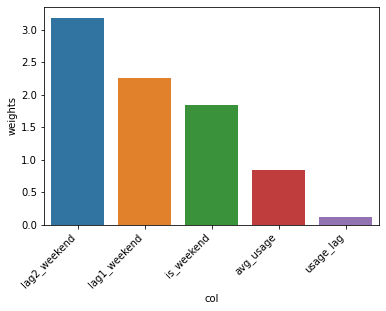

In [305]:
sns.barplot(data=importance[:5], x="col", y="weights")
plt.xticks(rotation=45, ha="right")

In [306]:
importance

,weights,col
10,3.190107,lag2_weekend
8,2.258145,lag1_weekend
7,1.845225,is_weekend
12,0.841778,avg_usage
9,0.124208,usage_lag
11,0.076702,usage_lag2
3,0.059482,max_visibility_miles
13,0.056982,min_usage
14,0.032383,max_usage
2,0.028983,max_temperature_f


In [311]:
yhat = best["model"].predict(X_te)


3.593477361585655

<AxesSubplot:xlabel='usage', ylabel='Count'>

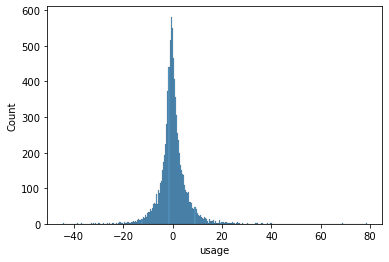

In [309]:
sns.histplot(y_te - yhat)